In [ ]:
! pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mamba install -c conda-forge rdkit

In [ ]:
# from bio_embeddings.embed import ProtTransBertBFDEmbedder

In [ ]:
! pip install PyTDC

In [ ]:
# ! pip install dgl
! pip install dgl-cu101

In [ ]:
! pip install dgllife

In [ ]:
import dgllife
from dgllife import data
import dgl

In [ ]:
import numpy as np

In [ ]:
import pandas as pd
import time

In [ ]:
import shutil
import torch
import torch.nn as nn

from copy import deepcopy
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import Meter, smiles_to_bigraph, CanonicalAtomFeaturizer, EarlyStopping, CanonicalBondFeaturizer, BaseAtomFeaturizer
from hyperopt import fmin, tpe
from torch.optim import Adam
from torch.utils.data import DataLoader

In [ ]:
from rdkit import Chem

In [ ]:
import networkx as nx

In [ ]:
from collections import defaultdict
from dgl import backend as F
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import ConcatFeaturizer, EarlyStopping
from dgllife.utils import BaseAtomFeaturizer, atom_type_one_hot, atom_degree_one_hot, \
    atom_formal_charge, atom_num_radical_electrons, \
    atom_hybridization_one_hot, atom_total_num_H_one_hot, atom_implicit_valence_one_hot, atom_is_aromatic
from dgllife.utils.featurizers import BaseBondFeaturizer
from dgl.data.utils import save_graphs, load_graphs
from functools import partial
from dgllife.model import AttentiveFPPredictor

## Create embeddings:

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# embedders = []
# seq_4o2b = 'MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYRQLFHPEQLITGKEDAANNYARGHYTIGKEIIDLVLDRIRKLADQCTGLQGFLVFHSFGGGTGSGFTSLLMERLSVDYGKKSKLEFSIYPAPQVSTAVVEPYNSILTTHTTLEHSDCAFMVDNEAIYDICRRNLDIERPTYTNLNRLISQIVSSITASLRFDGALNVDLTEFQTNLVPYPRIHFPLATYAPVISAEKAYHEQLSVAEITNACFEPANQMVKCDPRHGKYMACCLLYRGDVVPKDVNAAIATIKTKRSIQFVDWCPTGFKVGINYQPPTVVPGGDLAKVQRAVCMLSNTTAIAEAWARLDHKFDLMYAKRAFVHWYVGEGMEEGEFSEAREDMAALEKDYEEVGVDSVEGEGEEEGEEYMREIVHIQAGQCGNQIGAKFWEVISDEHGIDPTGSYHGDSDLQLERINVYYNEATGNKYVPRAILVDLEPGTMDSVRSGPFGQIFRPDNFVFGQSGAGNNWAKGHYTEGAELVDSVLDVVRKESESCDCLQGFQLTHSLGGGTGSGMGTLLISKIREEYPDRIMNTFSVMPSPKVSDTVVEPYNATLSVHQLVENTDETYCIDNEALYDICFRTLKLTTPTYGDLNHLVSATMSGVTTCLRFPGQLNADLRKLAVNMVPFPRLHFFMPGFAPLTSRGSQQYRALTVPELTQQMFDSKNMMAACDPRHGRYLTVAAIFRGRMSMKEVDEQMLNVQNKNSSYFVEWIPNNVKTAVCDIPPRGLKMSATFIGNSTAIQELFKRISEQFTAMFRRKAFLHWYTGEGMDEMEFTEAESNMNDLVSEYQQYQDATADEQGEFEEEEGEDEAMADMEVIELNKCTSGQSFEVILKPPSFDGVPEFNASLPRRRDPSLEEIQKKLEAAEERRKYQEAELLKHLAEKREHEREVIQKAIEENNNFIKMAKEKLAQKMESNKENREAHLAAMLERLQEKDKHAEEVRKNKELKEEASRMYTFVVRDENSSVYAEVSRLLLATGQWKRLRKDNPRFNLMLGERNRLPFGRLGHEPGLVQLVNYYRGADKLCRKASLVKLIKTSPELSESCTWFPESYVIYPTNLKTPVAPAQNGIRHLINNTRTDEREVFLAAYNRRREGREGNVWIAKSSAGAKGEGILISSEASELLDFIDEQGQVHVIQKYLEKPLLLEPGHRKFDIRSWVLVDHLYNIYLYREGVLRTSSEPYNSANFQDKTCHLTNHCIQKEYSKNYGRYEEGNEMFFEEFNQYLMDALNTTLENSILLQIKHIIRSCLMCIEPAISTKHLHYQSFQLFGFDFMVDEELKVWLIEVNGAPACAQKLYAELCQGIVDVAISSVFPLADTGQKTSQPTSIFIKLHHHHHH'
# seq_6wvr = 'MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYRQLFHPEQLITGKEDAANNYARGHYTIGKEIIDLVLDRIRKLADQCTGLQGFLVFHSFGGGTGSGFTSLLMERLSVDYGKKSKLEFSIYPAPQVSTAVVEPYNSILTTHTTLEHSDCAFMVDNEAIYDICRRNLDIERPTYTNLNRLISQIVSSITASLRFDGALNVDLTEFQTNLVPYPRIHFPLATYAPVISAEKAYHEQLSVAEITNACFEPANQMVKCDPRHGKYMACCLLYRGDVVPKDVNAAIATIKTKRSIQFVDWCPTGFKVGINYQPPTVVPGGDLAKVQRAVCMLSNTTAIAEAWARLDHKFDLMYAKRAFVHWYVGEGMEEGEFSEAREDMAALEKDYEEVGVDSVEGEGEEEGEEYMREIVHIQAGQCGNQIGAKFWEVISDEHGIDPTGSYHGDSDLQLERINVYYNEAAGNKYVPRAILVDLEPGTMDSVRSGPFGQIFRPDNFVFGQSGAGNNWAKGHYTEGAELVDSVLDVVRKESESCDCLQGFQLTHSLGGGTGSGMGTLLISKIREEYPDRIMNTFSVMPSPKVSDTVVEPYNATLSVHQLVENTDETYSIDNEALYDICFRTLKLTTPTYGDLNHLVSATMSGVTTCLRFPGQLNADLRKLAVNMVPFPRLHFFMPGFAPLTSRGSQQYRALTVPELTQQMFDSKNMMAACDPRHGRYLTVAAIFRGRMSMKEVDEQMLNVQNKNSSYFVEWIPNNVKTAVCDIPPRGLKMSATFIGNSTAIQELFKRISEQFTAMFRRKAFLHWYTGEGMDEMEFTEAESNMNDLVSEYQQYQDATADEQGEFEEEEGEDEA'
# seq_4igh = 'GDERFYAEHLMPTLQGLLDPESAHRLAVRFTSLGLLPRARFQDSDMLEVRVLGHKFRNPVGIAAGFDKHGEAVDGLYKMGFGFVEIGSVTPKPQEGNPRPRVFRLPEDQAVINRYGFNSHGLSVVEHRLRARQQKQAKLTEDGLPLGVNLGKNKTSVDAAEDYAEGVRVLGPLADYLVVNVSSPNTAGLRSLQGKAELRRLLTKVLQERDGLRRVHRPAVLVKIAPDLTSQDKEDIASVVKELGIDGLIVTNTTVSRPAGLQGALRSETGGLSGKPLRDLSTQTIREMYALTQGRVPIIGVGGVSSGQDALEKIRAGASLVQLYTALTFWGPPVVGKVKRELEALLKEQGFGGVTDAIGADHRRLEHHHHHH'
# seq_4o4i = 'MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGDDSFNTFFSETGAGKHVPRAVFVDLEPTVIDEVRTGTYRQLFHPEQLITGKEDAANNYARGHYTIGKEIIDLVLDRIRKLADQCTGLQGFLVFHSFGGGTGSGFTSLLMERLSVDYGKKSKLEFSIYPAPQVSTAVVEPYNSILTTHTTLEHSDCAFMVDNEAIYDICRRNLDIERPTYTNLNRLISQIVSSITASLRFDGALNVDLTEFQTNLVPYPRIHFPLATYAPVISAEKAYHEQLSVAEITNACFEPANQMVKCDPRHGKYMACCLLYRGDVVPKDVNAAIATIKTKRSIQFVDWCPTGFKVGINYQPPTVVPGGDLAKVQRAVCMLSNTTAIAEAWARLDHKFDLMYAKRAFVHWYVGEGMEEGEFSEAREDMAALEKDYEEVGVDSVEGEGEEEGEEYMREIVHIQAGQCGNQIGAKFWEVISDEHGIDPTGSYHGDSDLQLERINVYYNEATGNKYVPRAILVDLEPGTMDSVRSGPFGQIFRPDNFVFGQSGAGNNWAKGHYTEGAELVDSVLDVVRKESESCDCLQGFQLTHSLGGGTGSGMGTLLISKIREEYPDRIMNTFSVMPSPKVSDTVVEPYNATLSVHQLVENTDETYCIDNEALYDICFRTLKLTTPTYGDLNHLVSATMSGVTTCLRFPGQLNADLRKLAVNMVPFPRLHFFMPGFAPLTSRGSQQYRALTVPELTQQMFDSKNMMAACDPRHGRYLTVAAIFRGRMSMKEVDEQMLNVQNKNSSYFVEWIPNNVKTAVCDIPPRGLKMSATFIGNSTAIQELFKRISEQFTAMFRRKAFLHWYTGEGMDEMEFTEAESNMNDLVSEYQQYQDATADEQGEFEEEEGEDEAMADMEVIELNKCTSGQSFEVILKPPSFDGVPEFNASLPRRRDPSLEEIQKKLEAAEERRKYQEAELLKHLAEKREHEREVIQKAIEENNNFIKMAKEKLAQKMESNKENREAHLAAMLERLQEKDKHAEEVRKNKELKEEASRMYTFVVRDENSSVYAEVSRLLLATGQWKRLRKDNPRFNLMLGERNRLPFGRLGHEPGLVQLVNYYRGADKLCRKASLVKLIKTSPELSESCTWFPESYVIYPTNLKTPVAPAQNGIRHLINNTRTDEREVFLAAYNRRREGREGNVWIAKSSAGAKGEGILISSEASELLDFIDEQGQVHVIQKYLEKPLLLEPGHRKFDIRSWVLVDHLYNIYLYREGVLRTSSEPYNSANFQDKTCHLTNHCIQKEYSKNYGRYEEGNEMFFEEFNQYLMDALNTTLENSILLQIKHIIRSCLMCIEPAISTKHLHYQSFQLFGFDFMVDEELKVWLIEVNGAPACAQKLYAELCQGIVDVAISSVFPLADTGQKTSQPTSIFIKLHHHHHH'
# seq_2am9 = 'ETTQKLTVSHIEGYECQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPIARELHQFTFDLLIKSHMVSVDFPEMMAEIISVQVPKILSGKVKPIYFHTQ'
# seq_3d0e = 'KVTMNDFDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQNTRHPFLTALKYAFQTHDRLCFVMEYANGGELFFHLSRERVFTEERARFYGAEIVSALEYLHSRDVVYRDIKLENLMLDKDGHIKITDFGLCKEGISDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHERLFELILMEEIRFPRTLSPEAKSLLAGLLKKDPKQRLGGGPSDAKEVMEHRFFLSINWQDVVQKKLLPPFKPQVTSEVDTRYFDDEFTAQSITITPPDRYDSLGLLELDQRTHFPQFDYSASIR'

In [ ]:
# sequences = [seq_4o2b, seq_6wvr, seq_4igh, seq_4o4i, seq_2am9, seq_3d0e]
# embedder = ProtTransBertBFDEmbedder()
# embedder = CPCProtEmbedder()

In [ ]:
# embeddings = [embedder.reduce_per_protein(embedder.embed(seq)) for seq in sequences]

In [ ]:
# add one more embedding for the GTP version of 4o2b
# probably not the smartest way to do this :D 
# embeddings.append(embeddings[0])

In [ ]:
for i in embeddings:
  print(i.shape)

(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)


In [ ]:
# convert to tensor
# embeddings = [torch.tensor(e) for e in embeddings]

In [ ]:
# add passing to make the sequences of the same length
# padded_embeddings = pad_sequence(embeddings, batch_first=True)

In [ ]:
# print(padded_embeddings.shape)
# padded_embeddings = padded_embeddings.permute(1, 0, 2)
# print(padded_embeddings.shape)

In [ ]:
# padded_embeddings = padded_embeddings.tolist()

In [ ]:
# import pandas as pd

In [ ]:
# receptor = ['receptor_4o2b_GTP.pdbqt', 'receptor_6wvr.pdbqt', '4igh.pdbqt', 'receptor_4o4i.pdbqt', '2am9.pdbqt', '3d0e.pdbqt', 'receptor_4o2b.pdbqt' ]

In [ ]:
# embeddings = pd.DataFrame(list(zip(receptor, padded_embeddings)),
              # columns=['receptor','embedding'])

In [ ]:
# embeddings.to_csv('inhouse_protransbert_1024.csv')

In [ ]:
embeddings = pd.read_csv('inhouse_protransbert_1024.csv', converters={'embedding': eval})

## Create Train/Validation datasets:

In [ ]:
df = pd.read_csv("BA_train.csv")

In [ ]:
df.drop(df.loc[df['Energy']== -1].index, inplace=True)
df.drop(df.loc[df['receptor']== 'receptor_4o2b.pdbqt'].index, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df.head()

In [ ]:
df.receptor.value_counts()

In [ ]:
df = df.groupby(['SMILES', 'receptor']).mean()
df = df.reset_index()

In [ ]:
df = pd.merge(df, embeddings, on='receptor', how='inner')
df = df.dropna()
df

## Generating Testing Dataset:

In [ ]:
df_test = pd.read_csv("BA_test.csv")

In [ ]:
df_test.drop(df_test.loc[df_test['Energy']== -1].index, inplace=True)
df.drop(df.loc[df['receptor']== 'receptor_4o2b.pdbqt'].index, inplace=True)
df_test = df_test.reset_index(drop=True)
df_test = df_test.reset_index()
df_test.receptor.value_counts()

## Create a test set for each receptor:

In [ ]:
df_test = df_test[['SMILES', 'Energy', 'receptor']]
df_test = df_test.groupby(['SMILES', 'receptor']).mean()
test = df_test.reset_index()
test = pd.merge(test, embeddings, on='receptor', how='outer')
print(test)

In [ ]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, valid, _ = train_validate_test_split(df, 0.8, 0.2, seed=100)
# train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

## Creating Graphs from CSV
## Taken from [here](https://github.com/awslabs/dgl-lifesci/blob/master/examples/property_prediction/pubchem_aromaticity/configure.py)

In [ ]:
node_featurizer = BaseAtomFeaturizer(
        featurizer_funcs={'hv': ConcatFeaturizer([
            partial(atom_type_one_hot, allowable_set=[
                'C', 'N', 'O'],
                    encode_unknown=True),
            partial(atom_degree_one_hot, allowable_set=list(range(5))),
            partial(atom_implicit_valence_one_hot, allowable_set=list(range(5))),
            atom_is_aromatic,
            atom_hybridization_one_hot, 
            atom_total_num_H_one_hot
        ],
        )})

In [ ]:
edge_featurizer = BaseBondFeaturizer({'he': lambda bond: [0 for _ in range(10)]})

In [ ]:
class GraphWithProtein(MoleculeCSVDataset):
    def __init__(self,
                 df,
                 smiles_to_graph=smiles_to_bigraph,
                 node_featurizer=None,
                 edge_featurizer=None,
                 smiles_column='SMILES',
                 cache_file_path='fps_dglgraph.bin',
                 task_names=['Energy'],
                 load=True,
                 log_every=1000):

        self.protein = torch.tensor(df['embedding'].tolist()).float()
        self.load_full = True

        super(GraphWithProtein, self).__init__(df=df,
                                            smiles_to_graph=smiles_to_graph,
                                            node_featurizer=node_featurizer,
                                            edge_featurizer=edge_featurizer,
                                            smiles_column=smiles_column,
                                            cache_file_path=cache_file_path,
                                            task_names=task_names,
                                            load=load,
                                            log_every=log_every)

    def __getitem__(self, item):
        if self.load_full:
            return self.smiles[item], self.graphs[item], self.labels[item], self.protein[item]
        else:
            return self.smiles[item], self.graphs[item], self.labels[item]

In [ ]:
train_set = GraphWithProtein(df=train, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph1a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
val_set = GraphWithProtein(df=valid, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph2a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)

In [ ]:
test_set = GraphWithProtein(df=test, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph3a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)

In [ ]:
test_4o2b_GTP = test.loc[test['receptor'] == 'receptor_4o2b_GTP.pdbqt']
test_4o2b_GTP = test_4o2b_GTP[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_6wvr = test.loc[test['receptor'] == 'receptor_6wvr.pdbqt']
test_6wvr = test_6wvr[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_4o2b = test.loc[test['receptor'] == 'receptor_4o2b.pdbqt']
test_4o2b = test_4o2b[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_3d0e = test.loc[test['receptor'] == '3d0e.pdbqt']
test_3d0e = test_3d0e[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_4igh = test.loc[test['receptor'] == '4igh.pdbqt']
test_4igh = test_4igh[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_4o4i = test.loc[test['receptor'] == 'receptor_4o4i.pdbqt']
test_4o4i = test_4o4i[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

test_2am9 = test.loc[test['receptor'] == '2am9.pdbqt']
test_2am9 = test_2am9[['SMILES', 'Energy', 'embedding']].reset_index(drop=True)

In [ ]:
test_4o2b_GTP_set = GraphWithProtein(df=test_4o2b_GTP, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph4a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
test_6wvr_set = GraphWithProtein(df=test_6wvr, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph5a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
# test_4o2b_set = GraphWithProtein(df=test_4o2b, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph6a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
test_3d0e_set = GraphWithProtein(df=test_3d0e, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph7a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
test_4igh_set = GraphWithProtein(df=test_4igh, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph8a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
test_4o4i_set = GraphWithProtein(df=test_4o4i, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph9a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)
test_2am9_set = GraphWithProtein(df=test_2am9, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='/content/drive/MyDrive/Graph_Neural_Networks/Attentive_FP 3.0/DGL Data/dglgraph10a.bin', smiles_column='SMILES', task_names=['Energy'], log_every=1000)

In [ ]:
g = train_set[300]
G = g[1]

In [ ]:
g[3].shape

In [ ]:
G.edata['he'].shape

## Visualization

In [ ]:
nx_G = G.to_networkx().to_undirected()

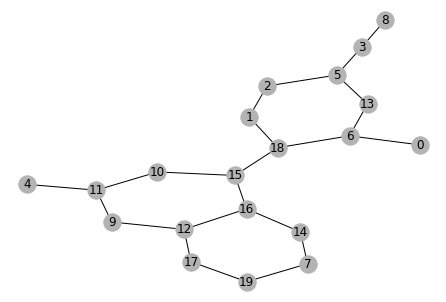

In [ ]:
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Test built-in dataset

## Testing Networks

In [ ]:
graph_feat_size = 100
num_layers = 2
num_timesteps = 2
node_feat_size = 25
edge_feat_size = 10
n_tasks = 1
dropout = 0.2
weight_decay = 10 ** (-5.0)
lr = 10 ** (-3.5)
batch_size = 64
num_epochs = 800
mode = 'lower'
patience = 20

In [ ]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and a binary
        mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """
    masks = None
    smiles, graphs, labels, protein = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    protein = torch.stack(protein, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, protein, masks
#     return smiles, bg, labels, masks

In [ ]:
def set_random_seed(seed=0):
    """Set random seed.
    Parameters
    ----------
    seed : int
        Random seed to use. Default to 0.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [ ]:
def regress(model, bg, protein):
    bg = bg.to(device)
    atom_feats, bond_feats = bg.ndata.pop('hv'), bg.edata.pop('he')
    atom_feats, bond_feats = atom_feats.to(device), bond_feats.to(device)
    return model(bg, protein, atom_feats, bond_feats)
    
def run_a_train_epoch(epoch, model, data_loader,
                      loss_criterion, optimizer):
    model.train()
    train_meter_mae = Meter()
    train_meter_mse = Meter()
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, protein, masks = batch_data
        protein = protein.to(device)
        labels, masks = labels.to(device), masks.to(device)
        prediction = regress(model, bg, protein)
        loss = (loss_criterion(prediction, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter_mae.update(prediction, labels, masks)
        train_meter_mse.update(prediction, labels, masks)
    total_score_mae = np.mean(train_meter_mae.compute_metric('mae'))
    total_score_mse = np.mean(train_meter_mse.compute_metric('rmse'))
    print('epoch {:d}, training {} {:.4f}, training {} {:.4f}'.format(
        epoch + 1,  'mae', total_score_mae, 'mse', total_score_mse**2))

def run_an_eval_epoch(model, data_loader):
    model.eval()
    eval_meter_mae = Meter()
    eval_meter_mse = Meter()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, protein, masks = batch_data
            protein = protein.to(device)
            labels = labels.to(device)
            prediction = regress(model, bg, protein)
            eval_meter_mae.update(prediction, labels, masks)
            eval_meter_mse.update(prediction, labels, masks)
        total_score_mae = np.mean(eval_meter_mae.compute_metric('mae'))
        total_score_mse = np.mean(eval_meter_mse.compute_metric('rmse'))
    return total_score_mae, total_score_mse**2

In [ ]:
seed = 100
set_random_seed(seed)

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                          shuffle=True, collate_fn=collate_molgraphs)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)

In [ ]:
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
import torch.nn.functional as F

In [ ]:
class AttentiveFPPredictor(nn.Module):

    def __init__(self,
                 node_feat_size,
                 edge_feat_size,
                 pr_input_size=1024,
                 pr_out_size=64,
                 num_layers=2,
                 num_timesteps=2,
                 graph_feat_size=100,
                 n_tasks=100,
                 dropout=0.):
        super(AttentiveFPPredictor, self).__init__()
        
        self.layer1 = nn.Linear(pr_input_size, 128)
        self.layer2 = nn.Linear(128, pr_out_size)
        self.layer3 = nn.Linear(n_tasks + pr_out_size, 64)
        self.layer4 = nn.Linear(64, 1)
        
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout)
        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(graph_feat_size, n_tasks)
        )
        

    def forward(self, g, fp, node_feats, edge_feats, get_node_weight=False):

        x1 = F.relu(self.layer1(fp))
        x1 = F.relu(self.layer2(x1))
        
        node_feats = self.gnn(g, node_feats, edge_feats)
        g_feats = self.readout(g, node_feats, get_node_weight)
        x2 = self.predict(g_feats)
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        
        return x
        

In [ ]:
model = AttentiveFPPredictor(node_feat_size=25,
                              edge_feat_size=10,
                              num_layers=num_layers,
                              num_timesteps=num_timesteps,
                              graph_feat_size=graph_feat_size,
                              n_tasks=n_tasks,
                              dropout=dropout)

In [ ]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
stopper = EarlyStopping(mode=mode, patience=patience)
model.to(device)

In [ ]:
num_epochs = 120

In [ ]:
for epoch in range(num_epochs):
    # Train
    train_start = time.time()
    run_a_train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    train_time = time.time() - train_start
    # Validation and early stop
    val_start = time.time()
    val_score_mae, val_score_mse = run_an_eval_epoch(model, val_loader)
    val_time = time.time() - val_start
    early_stop = stopper.step(val_score_mae, model)
    print('epoch {:d}/{:d}, validation {} {:.4f}, validation {} {:.4f}, best validation {} {:.4f}, train epoch time {}, validation epoch time {}'.format(
        epoch + 1, num_epochs, 'mae', val_score_mae, 'mse', val_score_mse,
        'mae', stopper.best_score, train_time, val_time))
    if early_stop:
      print('\nLoading the saved model')
      stopper.load_checkpoint(model)
      break

In [ ]:
def save_checkpoint(model, path):
  torch.save({'model_state_dict': model.state_dict()}, path + '.pth')

In [ ]:
 save_checkpoint(model, 'Inhouse_ProTransBert')

In [ ]:
checkpoint = torch.load('Inhouse_ProTransBert.pth', map_location=torch.device('cpu'))
# checkpoint = torch.load('Inhouse_ProTransBert.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    eval_meter_mae = Meter()
    eval_meter_mse = Meter()
    predictions = []
    originals = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, protein, masks = batch_data
            protein = protein.to(device)
            originals.append(labels)
            labels = labels.to(device)
            prediction = regress(model, bg, protein)
            predictions.append(prediction)
            eval_meter_mae.update(prediction, labels, masks)
            eval_meter_mse.update(prediction, labels, masks)
        total_score_mae = np.mean(eval_meter_mae.compute_metric('mae'))
        total_score_mse = np.mean(eval_meter_mse.compute_metric('rmse'))
    originals = torch.cat(originals, dim=0).squeeze().tolist()
    predictions = torch.cat(predictions, dim=0).squeeze().tolist()
    return total_score_mae, total_score_mse**2, originals, predictions

In [ ]:
def run_eval_on_data(model, data):
  test_loader = DataLoader(dataset=data, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)
  mae, mse, originals, predictions = evaluate_model(model, test_loader)
  return mae, mse, originals, predictions

In [ ]:
mae, mse, labels, preds = evaluate_model(model, test_loader)

In [ ]:
from tdc import Evaluator

In [ ]:
! pip install lifelines

In [ ]:
from lifelines.utils import concordance_index

In [ ]:
tdc_mse = Evaluator(name = 'MSE')
tdc_rmse = Evaluator(name = 'RMSE')
tdc_r2 = Evaluator(name = 'R2')
tdc_pcc = Evaluator(name = 'PCC')
tdc_sp = Evaluator(name = 'Spearman')

In [ ]:
print('mse: ', tdc_mse(labels, preds), 'rmse: ', tdc_rmse(labels, preds), 'r2: ', tdc_r2(labels, preds), 'pcc: ', tdc_pcc(labels, preds), 'spearman: ', tdc_sp(labels, preds), 'CI: ', concordance_index(labels, preds))

Per protein:

In [ ]:
print('mae and mse on the whole test dataset:', run_eval_on_data(model, test_set))
print('mae and mse on test_4o2b_GTP:', run_eval_on_data(model, test_4o2b_GTP_set))
print('mae and mse on test_6wvr:', run_eval_on_data(model, test_6wvr_set))
# print('mae and mse on test_4o2b:', run_eval_on_data(model, test_4o2b_set))
print('mae and mse on test_3d0e:', run_eval_on_data(model, test_3d0e_set))
print('mae and mse on test_4igh:', run_eval_on_data(model, test_4igh_set))
print('mae and mse on test_4o4i:', run_eval_on_data(model, test_4o4i_set))
print('mae and mse on test_2am9:', run_eval_on_data(model, test_2am9_set))

In [ ]:
testsets = [test_4o2b_GTP_set, test_6wvr_set, test_3d0e_set, test_4igh_set, test_4o4i_set, test_2am9_set]

In [ ]:
for ts in testsets:
  mae, mse, labels, preds = run_eval_on_data(model, ts)
  print('mae, mse', mae, mse)
  print('mse: ', tdc_mse(labels, preds), 'rmse: ', tdc_rmse(labels, preds), 'r2: ', tdc_r2(labels, preds), 'pcc: ', tdc_pcc(labels, preds), 'spearman: ', tdc_sp(labels, preds), 'CI: ', concordance_index(labels, preds))
  # plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':200})
  # plt.scatter(preds, labels, c=preds, cmap='Spectral')
  # plt.colorbar()
  # plt.xlim(0, 15)
  # plt.ylim(0, 15)
  # plt.xlabel('True Values')
  # plt.ylabel('Predicted Values')
  # plt.show()

  # plot = sns.jointplot(x=preds, y=labels, kind='reg', height=5, ratio=4, marginal_kws=dict(bins=25, fill=False))
  # plot.ax_marg_x.set_xlim(0, 15)
  # plot.ax_marg_y.set_ylim(0, 15)

  plt.show()